**分类模型优化**
首先插一张之前的模型调优总结
![tuning](images/model-tuning.png)

In [1]:
# 加载库
import time

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import pandas as pd

**加载数据**

In [4]:
iris = load_iris()
X = iris.data
y = iris.target
features = iris.feature_names
data = pd.DataFrame(X, columns=features)
data['target'] = y

In [10]:
# 概览信息
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [12]:
# 总计150个样本
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [9]:
# 数据集分为三类：0，1，2
data.target.value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

**Model Tuning**

In [13]:
# 可优化参数
# StandardScaler(), 标准化数据样本，减均值除方差
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
# 参数名必须是指定的格式：<estimator>__<parameter>， double _
param_grid = [
    {'svc__C':param_range,'svc__kernel':['linear']},
    {'svc__C':param_range,
     'svc__gamma':param_range,
     'svc__kernel':['rbf', 'poly', 'sigmoid']}]

In [23]:
# GridSearch, 网格搜索
start = time.time()
gs = GridSearchCV(estimator=pipe_svc, 
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=10)
gs = gs.fit(X, y)
print("网格搜索耗时（10进程）：%.3f s" % (time.time() - start))
print("最佳准确率：", gs.best_score_)
print('最佳参数：', gs.best_params_)

网格搜索耗时（10进程）：0.663 s
最佳准确率： 0.9800000000000001
最佳参数： {'svc__C': 1.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


In [26]:
# RandomizedSearch, 随机搜索
# 随机搜索的组合较少，相对于网格搜索会比较快,
# 但是结果也具有一定的不确定性
start = time.time()
rs = RandomizedSearchCV(estimator=pipe_svc, 
                 param_distributions=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=10)
rs = rs.fit(X, y)
print("随机搜索耗时（10进程）：%.3f s" % (time.time() - start))
print("最佳准确率：", rs.best_score_)
print('最佳参数：', rs.best_params_)

网格搜索耗时（10进程）：0.078 s
最佳准确率： 0.9333333333333333
最佳参数： {'svc__kernel': 'poly', 'svc__gamma': 100.0, 'svc__C': 0.01}


**分类的评价指标分析  --- 乳腺癌数据集**

In [30]:
# load dataset
data_url = """http://archive.ics.uci.edu/ml/machine-learning-databases/\
breast-cancer-wisconsin/wdbc.data"""
df = pd.read_csv(data_url)

In [33]:
# 第一列是id，第二列是target，后续列是特征
df.head()

,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [42]:
# simple data preprocessing
# target 数据从 object 转为 int, ['M','B'] to [1, 0]
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
y = LabelEncoder().fit_transform(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, # 测试集20%
                                                    stratify=y,  # 分层抽样
                                                    random_state=1)

In [43]:
# train
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

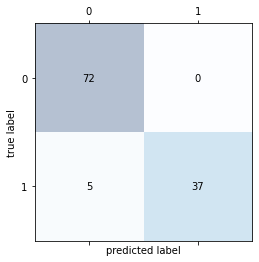

In [49]:
# 1，绘制混淆矩阵
conf_mx = confusion_matrix(y_true=y_test, y_pred=y_pred)

figure, ax = plt.subplots(figsize=(4, 4))  # 定义图片总大小， 4*4
# 显示矩阵图
ax.matshow(conf_mx,
          cmap= plt.cm.Blues,
          alpha=0.3)
for i in range(conf_mx.shape[0]):
    for j in range(conf_mx.shape[1]):
        ax.text(x=j,
                y=i,
                s=conf_mx[i,j],
                va='center',
                ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [56]:
# 2，准确率
from sklearn.metrics import accuracy_score
# normalize: True, 返回正确分类的比例；False，返回正确分类的样本个数
acc = accuracy_score(y_true=y_test, y_pred=y_pred, normalize=True)

acc

0.956140350877193

**3，召回率**

![recall](images/recall.png)

In [60]:
from sklearn.metrics import recall_score

rec_score = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')

rec_score

0.956140350877193

In [61]:
# 4，ROC曲线
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
y_pred = gs.fit(X_train,y_train).decision_function(X_test)

fpr,tpr,threshold = roc_curve(y_test, y_pred) # 计算真阳率和假阳率
roc_auc = auc(fpr,tpr) # 计算auc的值

In [67]:
threshold  # 阈值

array([ 6.64041515,  5.64041515,  0.25886113, -0.09639263, -0.3086203 ,
       -2.29967793, -2.36615462, -3.97691684])

<Figure size 432x288 with 0 Axes>

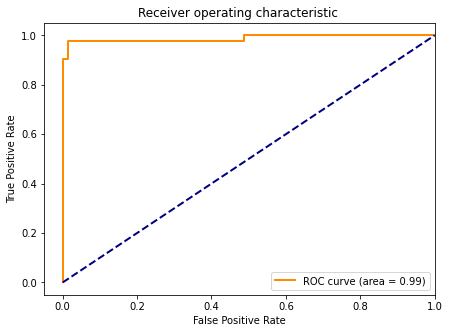

In [63]:
plt.figure()
lw = 2
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假阳率为横坐标，真阳率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

**Labeled Faces in the Wild (LFW)  -- 图像分类**

**加载数据**

In [8]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import StratifiedKFold
lfw = fetch_lfw_people()
X = lfw.data  # numpy array of shape (13233, 2914)
y = lfw.target  # numpy array of shape (13233,)
images = lfw.images  # numpy array of shape (13233, 62, 47)

(<matplotlib.image.AxesImage at 0x184c7e59ac0>, 5360)

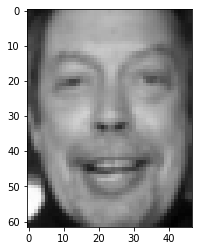

In [3]:
# 查看图片
plt.imshow(images[0], cmap=plt.cm.gray), y[0]

In [4]:
data = pd.DataFrame(X)

In [5]:
data_y = pd.DataFrame(y)

In [6]:
# 共5749个分类
data_y.value_counts()

1871    530
1047    236
5458    144
1404    121
1892    109
       ... 
2231      1
2230      1
2229      1
2228      1
5748      1
Length: 5749, dtype: int64

**训练模型**

In [14]:
# 复制样本5份, 
# 因为部分样本数为一，太少，不能用做K折；所以取巧了这里
X, y = X[:100], y[:100]
X, y = X.repeat(7, axis=0), y.repeat(7, axis=0)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
# 可优化参数
# StandardScaler(), 标准化数据样本，减均值除方差
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=42))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
# 参数名必须是指定的格式：<estimator>__<parameter>， double _
param_grid = [
    {'svc__C':param_range,'svc__kernel':['linear']},
    {'svc__C':param_range,
     'svc__gamma':param_range,
     'svc__kernel':['rbf', 'poly', 'sigmoid']}]

In [17]:
# SVC
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

1.0

In [18]:
# RandomizedSearch, 随机搜索
start = time.time()
rs = RandomizedSearchCV(estimator=pipe_svc, 
                 param_distributions=param_grid,
                 scoring='accuracy',
                cv =5,
                 n_jobs=10)
rs = rs.fit(X_train, y_train)
print("随机搜索耗时（10进程）：%.3f s" % (time.time() - start))
print("最佳准确率：", rs.best_score_)
print('最佳参数：', rs.best_params_)

随机搜索耗时（10进程）：2.150 s
最佳准确率： 1.0
最佳参数： {'svc__kernel': 'rbf', 'svc__gamma': 0.01, 'svc__C': 1.0}
